In [55]:
import numpy as np 
import cv2
import mediapipe as mp
import math
from ipywidgets import interact, IntSlider , Select
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# モジュールの準備
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=2)

In [59]:
class ClasifyPolymesh:
  def __init__(self, pu, pr, pb, pl):
    self.pu = pu
    self.pr = pr
    self.pb = pb
    self.pl = pl
    
  def judge(self, point):
    return point == self.pu or point == self.pr or point == self.pb or point == self.pl
  
  def store(self, x, y, point, array):
    if(point == self.pu):
      i = 0
    elif(point == self.pr):
      i = 1
    elif(point == self.pb):
      i = 2
    elif(point == self.pl):
      i = 3
    array[i] = [x, y]

In [57]:
def judge_right_eye(point):
  return point == 27 or point == 133 or point == 145 or point == 33
    
def store_in_right_eye_array(x, y, point, array):
  #上から上下左右
  if(point == 27):
    i = 0
  elif(point == 133):
    i = 1
  elif(point == 145):
    i = 2
  elif(point == 33):
    i = 3
  array[i] = [x, y]
  
def judge_left_eye(point):
  return point == 386 or point == 263 or point == 374 or point == 362
    
def store_in_left_eye_array(x, y, point, array):
  #上から上下左右
  if(point == 386):
    i = 0
  elif(point == 263):
    i = 1
  elif(point == 374):
    i = 2
  elif(point == 362):
    i = 3
  array[i] = [x, y]
  
#欲しい領域のみ回転させる。切り出しと回転が同時なイメージ。
def rot_cut(src_img, deg, center, size):
    rot_mat = cv2.getRotationMatrix2D(center, deg, 1.0)
    rot_mat[0][2] += -center[0]+size[0]/2 # -(元画像内での中心位置)+(切り抜きたいサイズの中心)
    rot_mat[1][2] += -center[1]+size[1]/2 # 同上
    return cv2.warpAffine(src_img, rot_mat, size)
  
def convert_deg(p1, p2):
  # 二点間の座標の差をとって傾きの角度を求める
  diff_x = p1[0] - p2[0]
  diff_y = p1[1] - p2[1]
  tilt = diff_y / diff_x
  arctan = math.atan(tilt)
  return arctan

def convert_size(points):
  # 長方形のサイズを求める
  width = math.sqrt((points[0][0] - points[2][0]) ** 2 + (points[0][1] - points[2][1]) ** 2)
  height = math.sqrt((points[1][0] - points[3][0]) ** 2 + (points[1][1] - points[3][1]) ** 2)
  size = [int(height), int(width)]
  return size

def convert_center(points):
  # 中心の座標を求める
  mid_x = (points[1][0] + points[3][0]) / 2
  mid_y = (points[1][1] + points[3][1]) / 2
  center = [mid_x, mid_y]
  top_arg = convert_deg(points[0], center)
  bottom_arg = convert_deg(points[2], center)
  top_len = 
  return center

[[1228, 1453], [1216, 1571], [1148, 1441], [1130, 1317]]


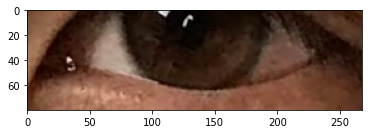

h:80, w:268


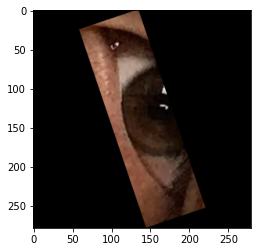

In [58]:
file = '../src/assets/rin_taoreru.jpg'
path='../src/assets/'
img = cv2.imread(file)
(h, w, c) = img.shape

right_eye = [0, 0, 0, 0]
left_eye = [0, 0, 0, 0]
# 点番号用のカウント変数
cnt = 0

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = faceMesh.process((imgRGB))
if results.multi_face_landmarks:
  for faceLms in results.multi_face_landmarks:
    # 全部の点を書きたいときはこの一文で十分

    # mpDraw.draw_landmarks(img, faceLms, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)

    # このループが顔の点分(468)回繰り返される
    # 特定の顔の点を記載したときはこの部分を調整する
    for id, lm in enumerate(faceLms.landmark):
      # 目をプロット
      if judge_right_eye(cnt):
        # 画像のサイズにfaceLms.landmarkのx,yの値を掛けることで座標になる
        x, y  = int(lm.x*w), int(lm.y*h)
        # 各パーツの配列に保存
        store_in_right_eye_array(x, y, cnt, right_eye)
        # 画像にプロット
        # cv2.drawMarker(img,(x,y),(255,0,0),markerType=cv2.MARKER_STAR,markerSize = 2)
      elif judge_left_eye(cnt):
        x, y = int(lm.x*w), int(lm.y*h)
        store_in_left_eye_array(x, y, cnt, left_eye)             
      cnt +=1

print(left_eye)
# print(convert_deg(right_eye))
# print(convert_center(right_eye))
# print(convert_size(right_eye)) 
deg_right = math.degrees(convert_deg(right_eye[1], right_eye[3]))          
cutimg_right = rot_cut(imgRGB, deg_right, convert_center(right_eye), convert_size(right_eye))
deg_left = math.degrees(convert_deg(left_eye[1], left_eye[3]))
cutimg_left = rot_cut(imgRGB, deg_left, convert_center(left_eye), convert_size(left_eye))

plt.imshow(cutimg_left)
plt.show()

(h, w, c) = cutimg_left.shape
reverse_canvas_size = int(math.sqrt(h*h + w*w))
revimg = cv2.getRotationMatrix2D([w/2, h/2], -deg_left, 1.0)
revimg[0][2] += int(reverse_canvas_size / 2) - (w/2) 
revimg[1][2] += int(reverse_canvas_size / 2) - (h/2)
revimg_left = cv2.warpAffine(cutimg_left, revimg, [reverse_canvas_size, reverse_canvas_size])
plt.imshow(revimg_left)
plt.show()